# Brent Oil Price: Exploratory Data Analysis & Time Series Properties

This notebook covers the initial exploratory data analysis of Brent crude oil prices, focusing on trend analysis, stationarity testing, and volatility patterns. This forms the foundation for later Bayesian change point modeling.

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Output path for figures
FIG_PATH = '../Docs/figures'
os.makedirs(FIG_PATH, exist_ok=True)

# Set aesthetic style
plt.style.use('ggplot')
sns.set_palette("viridis")

## 1. Data Loading and Preprocessing

We load the historical daily Brent oil prices and ensure the date index is properly formatted.

In [8]:
df = pd.read_csv('../data/raw/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

print(f"Data Coverage: {df['Date'].min()} to {df['Date'].max()}")
print(f"Total Observations: {len(df)}")
df.head()

Data Coverage: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
Total Observations: 9011


C:\Users\princ\AppData\Local\Temp\ipykernel_17812\830418167.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


## 2. Trend Analysis

Visualizing the price history allows us to identify major regimes and potential structural breaks visually.

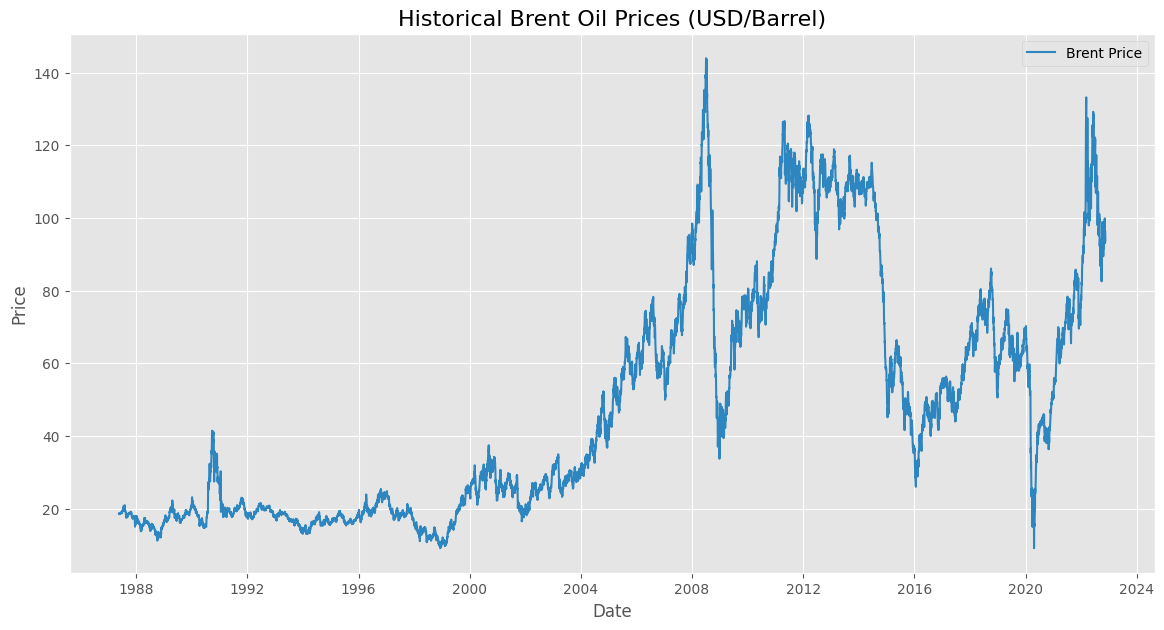

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Price'], label='Brent Price', color='#2E86C1')
plt.title('Historical Brent Oil Prices (USD/Barrel)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig(os.path.join(FIG_PATH, 'price_trend.png'))
plt.show()

## 3. Stationarity Testing (ADF Test)

Most statistical models require data to be stationary. We use the Augmented Dickey-Fuller (ADF) test to check for stationarity in raw prices and log returns.

In [10]:
def check_stationarity(series, title):
    result = adfuller(series.dropna())
    print(f"{title} ADF Statistic: {result[0]:.4f}")
    print(f"{title} p-value: {result[1]:.4e}")
    return result[1] < 0.05

is_stationary_raw = check_stationarity(df['Price'], "Raw Price")

Raw Price ADF Statistic: -1.9939
Raw Price p-value: 2.8927e-01


Since the raw price is likely non-stationary (p > 0.05), we calculate **log returns**.

In [11]:
df['Log_Return'] = np.log(df['Price']).diff()
is_stationary_returns = check_stationarity(df['Log_Return'], "Log Returns")

Log Returns ADF Statistic: -16.4271
Log Returns p-value: 2.4986e-29


## 4. Volatility Patterns

Volatility clustering is a common phenomenon in financial markets where high-volatility events tend to cluster together.

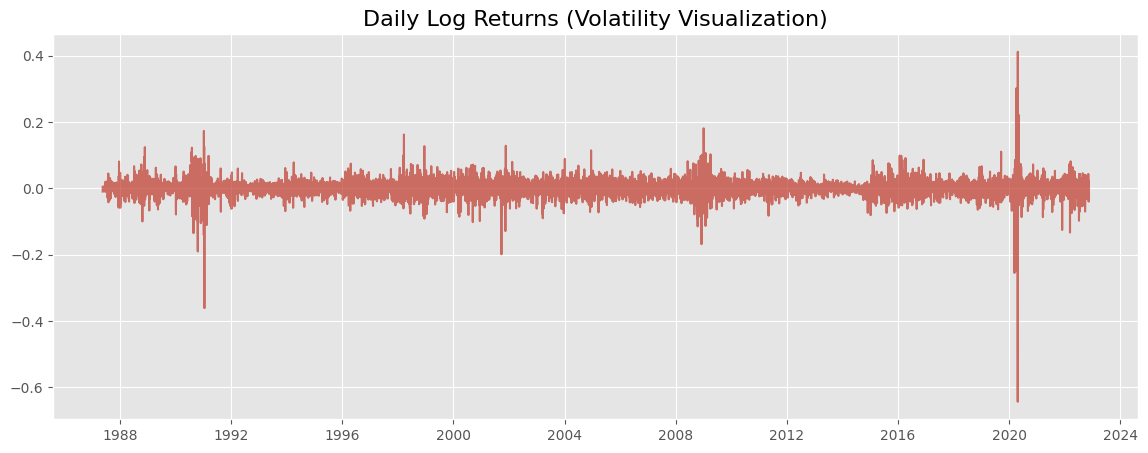

In [12]:
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Log_Return'], color='#C0392B', alpha=0.7)
plt.title('Daily Log Returns (Volatility Visualization)', fontsize=16)
plt.savefig(os.path.join(FIG_PATH, 'daily_returns_volatility.png'))
plt.show()

## 5. Change Point Model Explanation

The goal of change point analysis is to detect **structural breaks** in the time series. In a Bayesian framework, we model the change point $\tau$ as a random variable.

### Purpose
- Identifying regimes of stable prices.
- Detecting the exact timing of market shifts in response to shocks.

### Expected Outputs
- **Break Dates**: The most likely timestamp(s) for a shift.
- **Regime Parameters**: Mean and variance of prices before and after the break.

### Limitations
- **Sensitivity**: Models can be sensitive to prior choice.
- **Single vs Multiple**: A simple model might only find the most dominant break.